# API Calculation with Xarray + Dask
**Scott Wales, CLEX CMS**

Let's look at how we can calculate the [antecedent precipitation index (API)](https://glossary.ametsoc.org/wiki/Antecedent_precipitation_index) on a large dataset with Xarray and Dask.

API is defined from precipitation in a recursive way:
```
API(t0) = precip(t0)
API(t) = k * API(t - 1) + precip(t)
```
with k < 1, so that precipitation on previous days impacts the API but that impact decays over time.

To start out with, let's import some libraries and set up a Dask cluster - I'm running this notebook on https://ood.nci.org.au

In [1]:
import xarray
import numpy
import dask.array
import matplotlib.pyplot as plt

xarray.set_options(display_expand_data=False);

In [2]:
import climtas.nci
climtas.nci.Client()

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /node/ood-vn6/26243/proxy/8787/status,
Dashboard: /node/ood-vn6/26243/proxy/8787/status,Workers: 4
Total threads: 4,Total memory: 11.23 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39259,Workers: 4
Dashboard: /node/ood-vn6/26243/proxy/8787/status,Total threads: 4
Started: Just now,Total memory: 11.23 GiB
Comm: tcp://10.0.128.134:39111,Total threads: 1
Dashboard: /node/ood-vn6/26243/proxy/36843/status,Memory: 2.81 GiB
Nanny: tcp://127.0.0.1:35095,


For our sample dataset, I'll use FROGs, which provides precip from a number of datasets regridded to a common one degree grid. The data is chunked by default with one chunk per year in the time axis, since that's how the files themselves are split up.

In [3]:
ds = xarray.open_mfdataset('/g/data/ua8/Precipitation/FROGs/1DD_V1/ERA5/*.nc')
precip = ds.rain
precip

<xarray.DataArray 'rain' (time: 15341, lat: 180, lon: 360)>
dask.array<chunksize=(365, 180, 360), meta=np.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01T13:30:00 ... 2020-12-31
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
Attributes:
    standard_name:  lwe_precipitation_rate
    long_name:      Total precipitation, ERA5 reanalysis daily accumulated ra...
    units:          mm/day
    comment:        This daily precipitation is prepared by creating a accumu...

## Calculation on a single point

To start out with, let's make sure we can do the calculation on a single grid point.

Start out by saving the grid point's precip time series in a variable

In [4]:
precip_mel = precip.sel(lat=-37.81, lon=144.96, method='nearest').load()

```{admonition} Why the .load()?
I've done a `.load()` here because we'll be looping over time. Without the `.load()` Dask will try to read from the file at every loop iteration, with it it will only read from the file once - though this does come at the cost of more memory usage so we need to be carefull of how large the grid is that we're loading.
```

Now we can do the calculation. {func}`numpy.zeros_like` will create an empty array that's the same shape as the input array, which we'll use to store the API values. Then we can just implement the algorithm with a loop

In [5]:
# Empty array to store the output
api_mel = numpy.zeros_like(precip_mel)

k = 0.95

# Initial value is precip(t0)
api_mel[0] = precip_mel[0]

# Following values are k * api(t - 1) + precip(t)
for i in range(1, len(precip_mel)):
    api_mel[i] = k * api_mel[i - 1] + precip_mel[i]

Plotting the values they look ok, API is higher than the original precip values because of the accumulation but has the same sort of peak structure showing the decay is working as well.

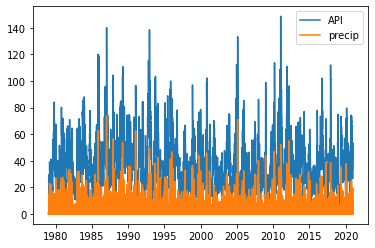

In [6]:
plt.plot(precip_mel.time, api_mel, label='API')
plt.plot(precip_mel.time, precip_mel, label='precip')
plt.legend();

## Calculation over the whole grid

With the caluclation working on a single grid point, let's look at expanding it to the whole grid. It's generally much more efficient to work on the whole grid at once, rather than single grid points one at a time, because of the way data gets laid out in the file.

The calculation looks much like the single grid point calculation, we've just added the extra dimensions when indexing the arrays

In [7]:
precip_year = precip.sel(time='1980').load()

api_year = numpy.zeros_like(precip_year)

api_year[0,:,:] = precip_year[0,:,:]

for i in range(1, precip_year.sizes['time']):
    api_year[i,:,:] = k * api_year[i - 1,:,:] + precip_year[i,:,:]

A quick plot of the final time looks reasonable

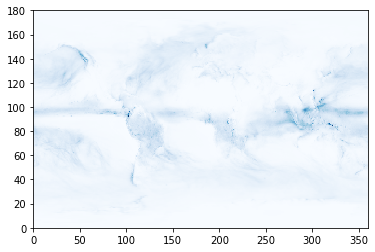

In [8]:
plt.pcolormesh(api_year[-1, :, :], cmap='Blues');

We've calculated a year of data, so let's save it to a netcdf file. First convert the numpy array to an xarray object - we can grab the coordinates from the original precip data, then save to file with {func}`xarray.DataArray.to_netcdf`

In [9]:
api_year = xarray.DataArray(api_year, name='api', coords=precip_year.coords)
api_year.to_netcdf('/local/w35/saw562/tmp/frogs_era5_api_1980.nc')

## Convert to a function

With a single year working we should make a function to consolodate where we've got to so far and to make sure we can easily change the year, without needing to do lots of copying and pasting.

This won't be the final function, for now this will only work properly for 1980, but it's important to be methodical and make sure what we've already done is still working.

In [10]:
def api_at_year(precip, year):
    """
    Returns the API measure for a given year
    """
    precip_year = precip.sel(time=year).load()

    api_year = numpy.zeros_like(precip_year)

    api_year[0,:,:] = precip_year[0,:,:]

    for i in range(1, precip_year.sizes['time']):
        api_year[i,:,:] = k * api_year[i - 1,:,:] + precip_year[i,:,:]
        
    api_year = xarray.DataArray(api_year, name='api', coords=precip_year.coords)
    
    return api_year

In [11]:
api_at_year(precip, '1980')

<xarray.DataArray 'api' (time: 366, lat: 180, lon: 360)>
0.01768 0.01768 0.01768 0.01768 0.01632 ... 4.527 4.523 4.533 4.528 4.527
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01T12:00:00 ... 1980-12-31T12:00:00
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5

## Passing the last timestep

With a basic function written we can now think about how to fix its problems. You might have noticed that in the previous function each year is calculated independently, so
```
API[1981-01-01] = precip[1981-01-01]
```
when it should in fact be
```
API[1981-01-01] = k * API[1980-12-31] + precip[1981-01-01]
```

We need some way to pass in the previous year's api values to our function, but only if we're not calculating the first year. We can do this with an argument that defaults to `None`, which looks like
```python
def api_at_year(precip, year, previous_api = None):
```

If a value is not given, like `api_at_year(precip, '1980')` then `previous_api` will be `None`, which we can check with an if statement:
```python
if previous_api is None:
    # First year
    api_year[0,:,:] = precip_year[0,:,:]
```

If we do pass a `previous_api` value, like `api_at_year(precip, '1981', api_1980)`, then we follow the else branch to use the correct formula:
```python
else:
    # Following years
    api_year[0,:,:] = k * previous_api[-1,:,:] + precip_year[0,:,:]
```

In [12]:
def api_at_year(precip, year, previous_api = None):
    """
    Returns the API measure for a given year
    """
    precip_year = precip.sel(time=year).load()

    api_year = numpy.zeros_like(precip_year)

    if previous_api is None:
        # First year
        api_year[0,:,:] = precip_year[0,:,:]
    else:
        # Following years
        api_year[0,:,:] = k * previous_api[-1,:,:] + precip_year[0,:,:]

    for i in range(1, precip_year.sizes['time']):
        api_year[i,:,:] = k * api_year[i - 1,:,:] + precip_year[i,:,:]
        
    api_year = xarray.DataArray(api_year, name='api', coords=precip_year.coords)
    
    return api_year

Now we can call the function multiple times for each year. We could store each year's values in its own variable, like
```python
api_1980 = api_at_year(precip, '1980')
api_1981 = api_at_year(precip, '1981', previous_api = api_1980)
```
but these variables will then stick around and fill up memory. It's better to save the values to file as we go, re-using the variable name:

In [13]:
api = api_at_year(precip, '1980')
api.to_netcdf('/local/w35/saw562/tmp/frogs_era5_api_1980.nc')

api = api_at_year(precip, '1981', previous_api = api)
api.to_netcdf('/local/w35/saw562/tmp/frogs_era5_api_1981.nc')

api = api_at_year(precip, '1982', previous_api = api)
api.to_netcdf('/local/w35/saw562/tmp/frogs_era5_api_1982.nc')

````{note}
Remember that everything on the right side of an assignment `=` gets evaluated before the variable is assigned, so in
```python
api = api_at_year(precip, '1981', previous_api = api)
```
the `api` on the right side refers to the value from the previous assignment, so the 1980 values
````

There's obvious repetition here, so we may as well convert it to a loop rather than writing the same two lines multiple times. I've set `api` to `None` explicitly so that 1980 looks the same as the rest of the years, it will still take the `if previous_api is None` branch of the if statement

In [14]:
api = None

for year in range(1980, 1990):
    print(year)
    api = api_at_year(precip, str(year), previous_api = api)
    api.to_netcdf(f'/local/w35/saw562/tmp/frogs_era5_api_{year}.nc')

1980
1981
1982
1983
1984
1985
1986
1987
1988
1989


Check that the files were properly created as expected - you may also want to try plotting some of the values in these files

In [15]:
! ls /local/w35/saw562/tmp/frogs_era5_api_*.nc

/local/w35/saw562/tmp/frogs_era5_api_1980.nc
/local/w35/saw562/tmp/frogs_era5_api_1981.nc
/local/w35/saw562/tmp/frogs_era5_api_1982.nc
/local/w35/saw562/tmp/frogs_era5_api_1983.nc
/local/w35/saw562/tmp/frogs_era5_api_1984.nc
/local/w35/saw562/tmp/frogs_era5_api_1985.nc
/local/w35/saw562/tmp/frogs_era5_api_1986.nc
/local/w35/saw562/tmp/frogs_era5_api_1987.nc
/local/w35/saw562/tmp/frogs_era5_api_1988.nc
/local/w35/saw562/tmp/frogs_era5_api_1989.nc
/local/w35/saw562/tmp/frogs_era5_api_full.nc


## Pure Dask (Advanced)

What we've done so far works well as long as a year's worth of data fits into memory. If it doesn't you can always split the data more finely, say by splitting the data by month instead of year.

Another way to go about it is to use the Dask chunks as the mechanism to split the data. The basic idea is very similar to what we've already done, we just need to learn how to do the loop over dask chunks instead of years.

Dask provides the {func}`dask.array.map_blocks` function that allows you to run a function on every chunk of an array. We do lose all of the Xarray metadata when we use this, we can only use basic numpy array functions. Here's the stripped down function we'll use with `map_blocks`:

In [16]:
def api_block(block, prev):
    """
    Returns the API measure for a dask chunk
    
    Args:
        block: a 3d numpy array with precip values, 
            time should be the first dimension
            
        prev: a 2d numpy array with the api value 
            immediately preceding the first time in
            block, or None if this is the first time
            step
    """
    api = numpy.zeros_like(block)

    if prev is None:
        api[0,:,:] = block[0,:,:]
    else:
        api[0,:,:] = k * prev + block[0,:,:]

    for i in range(1, block.shape[0]):
        api[i,:,:] = k * api[i - 1,:,:] + block[i,:,:]
    
    return api

`map_blocks` runs the function on each chunk independently, which is fine if we're chunked horizontally but if the chunking is over time then we need some way of passing in the previous time's API value.

Let's re-open the original dataset, adding some horizontal chunking this time, and see how we can deal with the previous timesteps. {attr}`~xarray.DataArray.data` will give you the Dask array from an Xarray object

In [17]:
ds = xarray.open_mfdataset('/g/data/ua8/Precipitation/FROGs/1DD_V1/ERA5/*.nc', chunks={'lat': 90, 'lon': 90})
precip = ds.rain
precip.data

dask.array<concatenate, shape=(15341, 180, 360), dtype=float32, chunksize=(366, 90, 90), chunktype=numpy.ndarray>

Once we have a Dask array, {attr}`dask.array.Array.blocks` lets us access the individual chunks. We can index `.blocks` as if it were a numpy array

In [18]:
precip.data.blocks[4,1,3]

dask.array<blocks, shape=(365, 90, 90), dtype=float32, chunksize=(365, 90, 90), chunktype=numpy.ndarray>

We can also iterate over `.blocks`, which will iterate over the first dimension, giving all the lat and lon chunks for that time chunk

In [19]:
for block in precip.data.blocks:
    display(block)
    break

dask.array<blocks, shape=(365, 180, 360), dtype=float32, chunksize=(365, 90, 90), chunktype=numpy.ndarray>

This loop now works like the loop over years that we had before. For each group of lat and lon chunks at a time chunk, use `map_blocks` to compute the API for those chunks. Save the final timestep from those chunks to pass in as the previous values for the next group. Once all of the groups have been processed concatenate them back together into a single array.

In [20]:
api_blocks = []
prev = None

for block in precip.data.blocks:
    api = dask.array.map_blocks(api_block, block, prev, meta=numpy.array((), dtype=block.dtype))
    prev = api[-1,:,:]
    
    api_blocks.append(api)
    
api_dask = dask.array.concatenate(api_blocks, axis=0)
api_dask

dask.array<concatenate, shape=(15341, 180, 360), dtype=float32, chunksize=(366, 90, 90), chunktype=numpy.ndarray>

Finally convert the Dask array to Xarray and save to a file

In [21]:
api = xarray.DataArray(api_dask, name='api', coords=precip.coords)
api.to_netcdf('/local/w35/saw562/tmp/frogs_era5_api_full.nc')
api

<xarray.DataArray 'api' (time: 15341, lat: 180, lon: 360)>
dask.array<chunksize=(365, 90, 90), meta=np.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01T13:30:00 ... 2020-12-31
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5

As a check, make sure the values from the chunked calculation match the very first 1D calculation

In [22]:
api = xarray.open_dataset('/local/w35/saw562/tmp/frogs_era5_api_full.nc')

numpy.testing.assert_almost_equal(api.api.sel(lat=-37.81, lon=144.96, method='nearest').values, api_mel, decimal=4)